In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import tqdm
import seaborn as sns

In [2]:
TENSORDTYPE = torch.float64

In [3]:
DEVICE = 'cuda:0'

In [4]:
LOGROOTDIR = './Plot-Figure1-v1'

All problem-specific functions accpet tensor arguments.

Take $f(t,x,a)$ as an example. We assume its inputs $t, x$ and $a$ are tensors with at least 1 dimension. All dimensions except the last are regarded as batch dimensions and are equivalent in function bodies. The outputs follow this rule too. This means even the time input $t$ and the value $f(t,x,a)$ are both scalar in their definition, we force them to be tensors in shape (1,) too.

We also adopt the sequence-first convention, which is standard in seq2seq training. Most Tensors have shape (T, M, D), where

- T : time axis
- M : batch axis
- D : original dim of this quantity

# Helper Function

In [5]:
def re_cumsum(t, dim):
    r'''torch.cumsum in reverse direction'''
    return t + torch.sum(t, dim, keepdim=True) - torch.cumsum(t, dim)

# Problem

Solve the following FBSDE
\begin{align*}
Y_t &= \frac{1}{n}\|W_T\|^2 + \int_t^T f_s\,ds - \int_t^T\langle Z_s, dW_s\rangle,
\end{align*}
with $f(s,\omega)\equiv-1$. The true solution is $Y_t = \frac{1}{n}\|W_t\|^2, Z_t = \frac{2}{n}W_t$.

In [6]:
class Example1(object):
    
    def __init__(self):
        self.H = 100
        self.dt = 0.01
        self.n = 10
        self.m = 16
    
    def sample_data(self):
        r'''sample batch of trajectories.
        
        Returns
        -------
        t_series : torch.Tensor
            with shape (H+1, M, 1)
        x_series : torch.Tensor
            with shape (H+1, M, N)
        w_series : torch.Tensor
            with shape (H+1, M, N). Note that w_series[0] is all zeros.
        g_series : torch.Tensor
            with shape (H+1, M, N). Note that g_series[-1] is the terminal cost.
        r_series : torch.Tensor
            with shape (H+1, M, N). The tail cost.
            $$r[i] = g[-1] + \Delta t \sum_{k=i}^{H-1}g[k].$$
        '''
        t_series = torch.tensor([k*self.dt for k in range(self.H+1)], dtype=TENSORDTYPE, device=DEVICE)
        # reshape to (H+1, M, 1)
        ones = torch.ones(1, self.m, self.H+1, dtype=TENSORDTYPE, device=DEVICE)
        t_series = (ones*t_series).transpose(0, -1)

        dw = torch.normal(0., np.sqrt(self.dt), size=(self.H, self.m, self.n), dtype=TENSORDTYPE, device=DEVICE)
        dw_series = torch.cat([dw, torch.zeros_like(dw[0:1])], dim=0)

        dw = torch.cat([torch.zeros_like(dw[0:1]), dw], dim=0)
        w_series = dw.cumsum(dim=0)
        
        
        x_series = w_series.clone()
        
        g_series = self.g(t_series, x_series)
        g_series[-1] = self.phi(x_series[-1])
        
        r_series = torch.stack([g_series[i] for i in reversed(range(self.H))]).cumsum(dim=0) * self.dt + g_series[-1]
        r_series = torch.cat([g_series[-1:], r_series], dim=0)
        r_series = torch.stack([r_series[i] for i in reversed(range(self.H+1))])
        
#         r2_series = re_cumsum(g_series[:-1], dim=0) * self.dt + g_series[-1]
#         r2_series = torch.cat([r2_series, g_series[-1:]], dim=0)
#         assert torch.isclose(r_series, r2_series).all()
        
        return (
            t_series, x_series, w_series, g_series, r_series, dw_series,
        )
    
    
    def g(self, t, x):
        r'''the generator function (negative).
        
        Args
        ----
        t : torch.Tensor
            with shape (..., 1)
        x : torch.Tensor
            with shape (..., n)
        
        Returns
        -------
        out : torch.Tensor
            with shape (..., 1)
        '''
        return -torch.ones_like(t)
    
    def phi(self, x):
        r'''the terminal condition.
        
        Args
        ----
        x : torch.Tensor
            with shape (..., n)
        
        Returns
        -------
        out : torch.Tensor
            with shape (..., 1)
        '''
        return torch.sum(x * x, dim=-1, keepdim=True) / self.n

In [7]:
# test sample data
fbsde = Example1()

for _ in tqdm.trange(50):
    data = fbsde.sample_data()
    t, x, w, g, r, _ = data

    
    err = r - torch.stack([g[-1] + fbsde.dt * torch.sum(g[:i], dim=0) for i in reversed(range(g.shape[0]))])
    err = err.abs().max()
    
    if err > 1e-12:
        break

for s in data:
    print(s.shape)

100%|██████████| 50/50 [00:01<00:00, 43.76it/s]

torch.Size([101, 16, 1])
torch.Size([101, 16, 10])
torch.Size([101, 16, 10])
torch.Size([101, 16, 1])
torch.Size([101, 16, 1])
torch.Size([101, 16, 10])


# Model

## Basic Nets

In [8]:
class YNet(torch.nn.Module):
    
    def __init__(self):
        super().__init__()
        self.register_parameter("theta", torch.nn.Parameter(torch.tensor([-1.])))
        self.to(dtype=TENSORDTYPE, device=DEVICE)
        
    def forward(self, t, x):
        r'''predict value function at (t, x).
        
        Args
        ----
        t : torch.Tensor
            with shape (..., 1)
        x : torch.Tensor
            with shape (..., n)
        
        Returns
        -------
        out : torch.Tensor
            with shape (..., 1)
        '''
        return self.theta * torch.sum(x*x, dim=-1, keepdim=True)
    
    
class ZNet(torch.nn.Module):
    
    def __init__(self):
        super().__init__()
        self.register_parameter("theta", torch.nn.Parameter(torch.tensor([-1.])))

        self.to(dtype=TENSORDTYPE, device=DEVICE)
        
    def forward(self, t, x):
        r'''predict z value at (t, x).
        
        Args
        ----
        t : torch.Tensor
            with shape (..., 1)
        x : torch.Tensor
            with shape (..., n)
        
        Returns
        -------
        out : torch.Tensor
            with shape (..., n)
        '''
        return 2 * self.theta * x

In [9]:
class Model1(torch.nn.Module):
    r'''Deep BSDE'''
    
    def __init__(self):
        super().__init__()
        self.znet = ZNet()
        self.register_parameter("y0", torch.nn.Parameter(torch.tensor([1.])))
        
        self.to(dtype=TENSORDTYPE, device=DEVICE)
        
    def forward(self, t, x):
        return self.znet(t, x)
    
class Model2(torch.nn.Module):
    r'''ML'''
    def __init__(self):
        super().__init__()
        self.ynet = YNet()
 
        self.to(dtype=TENSORDTYPE, device=DEVICE)
        
    def forward(self, t, x):
        return self.ynet(t, x)
    
    
class Model3(torch.nn.Module):
    r'''Deep BSDE-ML'''
    def __init__(self):
        super().__init__()
        self.ynet = YNet()
        self.znet = ZNet()
        
        self.to(dtype=TENSORDTYPE, device=DEVICE)
        
    def forward(self, t, x):
        return self.ynet(t, x), self.znet(t,x)
    

class Model5(torch.nn.Module):
    
    def __init__(self):
        super().__init__()
        self.znet = ZNet()
        
        self.to(dtype=TENSORDTYPE, device=DEVICE)
        
    def forward(self, t, x):
        return self.znet(t, x)

# Calculate Loss

Loss 1 (Deep BSDE):
$$ \operatorname{\mathbb{E}} |\widetilde{Y}_t - y|^2. $$

In [10]:
def calc_loss_1(model, dt, t_series, x_series, w_series, g_series, r_series, dw_series):
    r'''Deep BSDE Loss'''
    z_series = model.znet(t_series, x_series)
    m0 = torch.sum(torch.sum(z_series*dw_series, dim=-1, keepdim=True), dim=0)
    loss = torch.square(r_series[0] - m0 - model.y0).mean()
    return loss

Loss 2 (Deep BSDE-ML):
$$ \operatorname{\mathbb{E}} |\widetilde{Y}_t - \operatorname{\mathbb{E}}\widetilde{Y}_t|^2. $$

In [11]:
def calc_loss_2(model, dt, t_series, x_series, w_series, g_series, r_series, dw_series):
    r'''Deep BSDE-ML Loss'''
    z_series = model.znet(t_series, x_series)
    m0 = torch.sum(torch.sum(z_series*dw_series, dim=-1, keepdim=True), dim=0)
    loss = (r_series[0] - m0).var()
    return loss

Loss 7 (ML):
$$ \int_t^T\operatorname{\mathbb{E}} |R_s - \tilde{v}_s|^2\,ds. $$

In [12]:
def calc_loss_7(model, dt, t_series, x_series, w_series, g_series, r_series, dw_series):
    r'''Martingale Loss'''
    y_series = model.ynet(t_series, x_series)
    loss = torch.sum(torch.square(r_series - y_series).mean(dim=1, keepdim=True)) * dt
    return loss

Loss 8:
$$ \int_t^T\operatorname{\mathbb{E}} |\widetilde{Y}_s - \tilde{v}_s|^2\,ds. $$

In [13]:
def calc_loss_8(model, dt, t_series, x_series, w_series, g_series, r_series, dw_series):
    y_series, z_series = model(t_series, x_series)
    m_series = re_cumsum(torch.sum(z_series*dw_series, dim=-1, keepdim=True), 0)
    m_series = torch.cat([m_series[:-1], torch.zeros_like(m_series[-1:])], dim=0)
    loss = torch.sum(torch.square(r_series - m_series - y_series).mean(dim=1, keepdim=True)) * dt
    return loss

# Train

100%|██████████| 200/200 [00:00<00:00, 473.57it/s]


<Axes: >

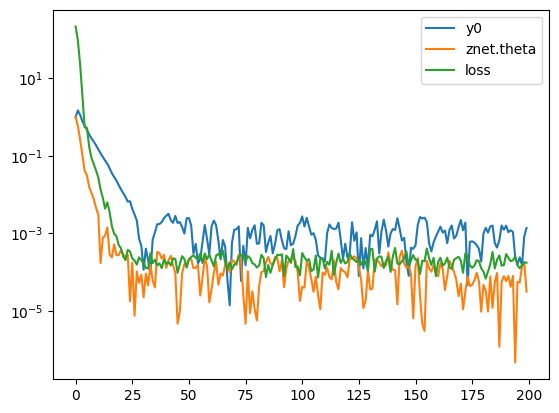

In [14]:
model = Model1()
calc_loss = calc_loss_1

sde = Example1()
sde.n = 100
sde.H = 100
sde.dt = 1e-2
sde.m = 16

true_values = {
    'ynet.theta': 1/sde.n,
    'znet.theta': 1/sde.n,
    'y0': 0.,
    'loss': 0.,
}

optimizer = torch.optim.SGD(
    [
        {'params': model.y0, 'lr': .1, },
        {'params': model.znet.parameters()},
    ],
    lr=0.001,
)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=.9999)
para_log = []

model.train(True)
optimizer.zero_grad()

for epi in tqdm.trange(200):
    para_log.append({n:v.item() for n, v in model.named_parameters()})

    data = sde.sample_data()
    loss = calc_loss(model, sde.dt, *data)
    
    para_log[-1]['loss'] = loss.item()
    
    loss.backward()
    
    # print(model.y0.grad.item(), model.znet.theta.grad.item())
    
    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=10000.)

    optimizer.step()
    scheduler.step()

    
    optimizer.zero_grad()

para_log = pd.DataFrame(para_log)
for col in para_log.columns:
    para_log[col] = (para_log[col] - true_values[col]).abs()
para_log.plot(logy=True)

# Train All

In [15]:
sde = Example1()
sde.n = 100
sde.H = 100
sde.dt = 1e-2
sde.m = 16

true_values = {
    'ynet.theta': 1/sde.n,
    'znet.theta': 1/sde.n,
    'y0': 0.,
    'loss': 0.,
}

para_logs = [[] for _ in range(4)]

for run_i in tqdm.trange(10):
    models = [Model1(), Model5(), Model2(), Model3()]
    calc_losses = [calc_loss_1, calc_loss_2, calc_loss_7, calc_loss_8]
    optimizers = [
        torch.optim.SGD([
            {'params': models[0].y0, 'lr': 0.1, },
            {'params': models[0].znet.parameters(), 'lr': 1e-3},
        ]),
        torch.optim.SGD([
            {'params': models[1].znet.parameters(), 'lr': 1e-3},
        ]),
        torch.optim.SGD([
            {'params': models[2].ynet.parameters(), 'lr': 1e-5},
        ]),
        torch.optim.SGD([
            {'params': models[3].ynet.parameters(), 'lr': 1e-5},
            {'params': models[3].znet.parameters(), 'lr': 1e-3},
        ]),
    ]

    for cri_i, (model, calc_loss, optimizer) in enumerate(zip(models, calc_losses, optimizers)):
        #scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.1**0.01)
        
        model.train(True)
        optimizer.zero_grad()

        for epi in range(200):
            para_logs[cri_i].append({'run': run_i, 'grad step': epi})
            para_logs[cri_i][-1].update({n:v.item() for n, v in model.named_parameters()})

            data = sde.sample_data()
            loss = calc_loss(model, sde.dt, *data)
            loss.backward()

            # torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=10000.)

            optimizer.step()
            #scheduler.step()

            optimizer.zero_grad()

100%|██████████| 10/10 [00:12<00:00,  1.21s/it]


/tmp/ipykernel_5233/493032672.py:22: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.lineplot(
/tmp/ipykernel_5233/493032672.py:22: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.lineplot(
/tmp/ipykernel_5233/493032672.py:22: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.lineplot(
/tmp/ipykernel_5233/493032672.py:22: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.lineplot(


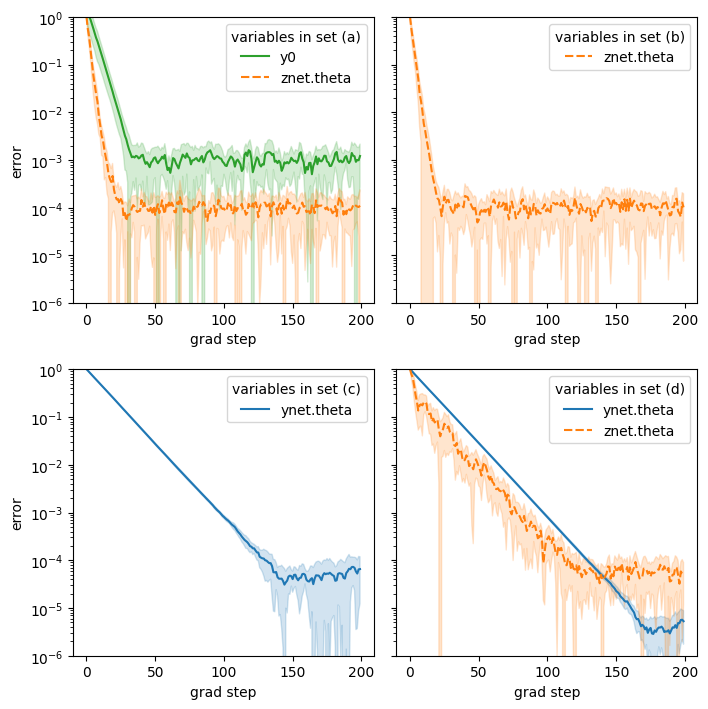

In [16]:
fig, axes = plt.subplots(2, 2, figsize=(7.2, 7.2), sharey=True)
axes = axes.flatten()
palette = {para: f'C{n}' for n, (para, v) in enumerate(true_values.items())}

# hard code dashes
style = {
    'y0': '',
    'znet.theta': (4,1.5),
    'ynet.theta': '',
    'loss': '',
}

for i, log in enumerate(para_logs):
    name = 'set ({})'.format(chr(97+i))
    df = pd.DataFrame(log)
    para_names = set(df.columns).intersection(set(true_values.keys()))
    for para in para_names:
        df[para] = (df[para] - true_values[para]).abs()
    data = df.melt(id_vars=['run', 'grad step'], value_vars=list(para_names), 
                   var_name=f'variables in {name}', value_name='error')
    
    sns.lineplot(
        x='grad step', y='error', ci='sd', hue=f'variables in {name}', ax=axes[i], data=data, palette=palette,
        dashes=style, style=f'variables in {name}',
    )
    
for i, ax in enumerate(axes):
    ax.set_yscale('log')
    ax.set_ylim(1e-6, 1e-0)
    
fig.tight_layout()

In [17]:
fig.savefig('./fig-1.pdf')